In [2]:
import kagglehub

path = kagglehub.dataset_download("mimdim/processed-rice-varieties-of-bangladesh")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/processed-rice-varieties-of-bangladesh


Aush: Attempting RGBe to RGB conversion.
BR-28: Attempting RGBe to RGB conversion.
BR-29: Attempting RGBe to RGB conversion.
Beroi: Attempting RGBe to RGB conversion.
Chinigura: Attempting RGBe to RGB conversion.
Ghee Bhog: Attempting RGBe to RGB conversion.
Katari Najir: Attempting RGBe to RGB conversion.
Katari Siddho: Attempting RGBe to RGB conversion.
Miniket: Attempting RGBe to RGB conversion.
Swarna: Attempting RGBe to RGB conversion.


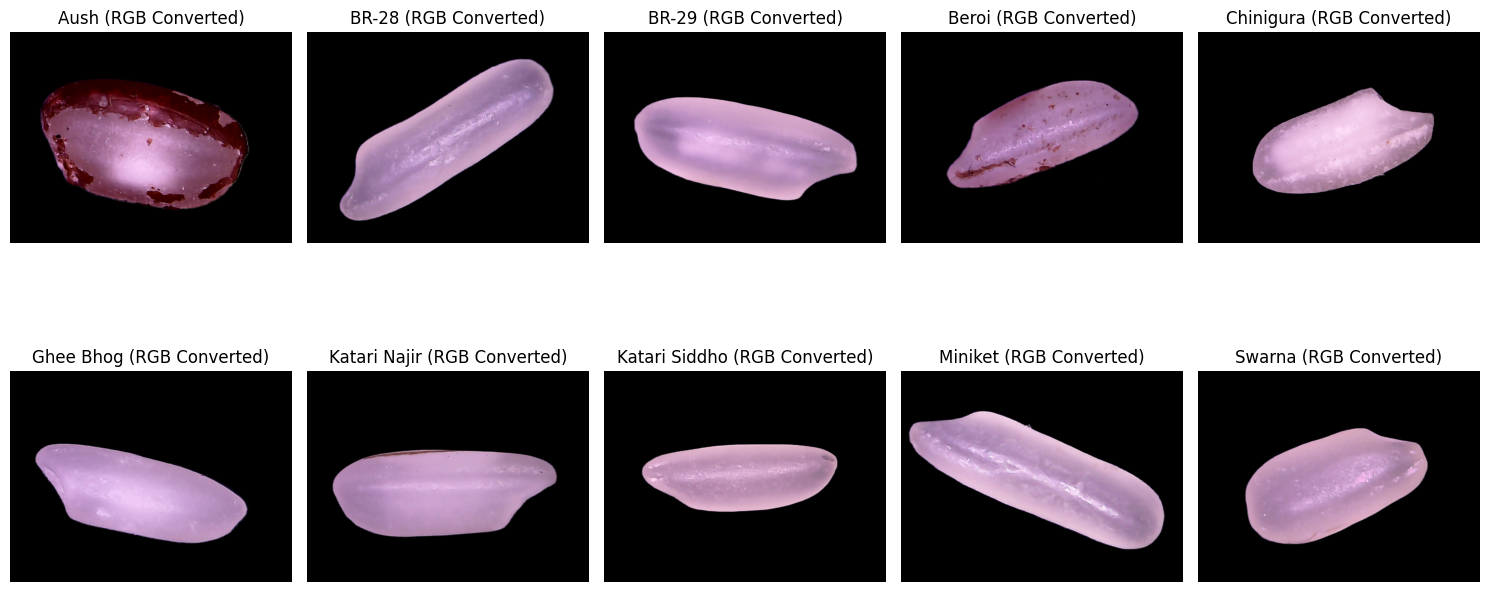

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# ---------- Function: RGBe → RGB (smooth, non-binary) ----------
def rgbe_to_rgb(img):
    """Converts a 4-channel RGBe image to smooth RGB (0-255)."""
    if img is None or img.ndim != 3 or img.shape[2] != 4:
        print("Warning: Input is not a valid 4-channel image for RGBe conversion.")
        return None

    r, g, b, e = cv2.split(img.astype(np.float32))
    scale = np.exp2(e - 128.0)
    rgb = np.stack([(r / 255) * scale, (g / 255) * scale, (b / 255) * scale], axis=-1)

    # Normalize to 0-255 without binary mapping
    rgb_min, rgb_max = rgb.min(), rgb.max()
    if rgb_max - rgb_min > 0:
        rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    else:
        rgb = np.zeros_like(rgb)
    rgb = (rgb * 255).astype(np.uint8)

    return rgb

# ---------- Folder paths ----------
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"

if not os.path.exists(dataset_dir):
    print(f"Error: Dataset directory not found at {dataset_dir}. Please ensure the dataset is downloaded and extracted correctly.")
else:
    classes = sorted(os.listdir(dataset_dir))

    plt.figure(figsize=(15, 8))

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_dir, cls)

        if not os.path.isdir(class_path):
            print(f"Skipping {cls}: Not a directory.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            print(f"{cls}: No image files found, skipping.")
            continue

        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        img_to_display = None
        title_text = cls

        if img is not None and isinstance(img, np.ndarray):
            if img.ndim == 3:  # Color images
                if img.shape[2] == 4:  # RGBe
                    print(f"{cls}: Attempting RGBe to RGB conversion.")
                    img_rgb = rgbe_to_rgb(img)
                    if img_rgb is not None:
                        img_to_display = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
                        title_text += " (RGB Converted)"
                    else:
                        print(f"{cls}: Failed RGBe to RGB conversion.")
                elif img.shape[2] == 3:  # Normal RGB
                    print(f"{cls}: Normal RGB image, using directly.")
                    img_to_display = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
                    title_text += " (Original RGB)"
                else:
                    print(f"{cls}: Unsupported number of channels ({img.shape[2]}), skipping.")
            elif img.ndim == 2:  # Grayscale
                print(f"{cls}: Grayscale image, skipping for visualization.")
            else:
                print(f"{cls}: Unsupported number of dimensions ({img.ndim}), skipping.")
        else:
            print(f"{cls}: Could not load image at {img_path} or it is not a valid numpy array, skipping.")

        # Plotting
        plt.subplot(2, (len(classes) + 1) // 2, i + 1)
        if img_to_display is not None:
            plt.imshow(img_to_display)
            plt.title(title_text)
        else:
            plt.text(0.5, 0.5, "Image Skipped", horizontalalignment='center', verticalalignment='center')
            plt.title(title_text + " (Skipped)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
import os
import shutil
import numpy as np

dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
split_base_dir = '/kaggle/working/split_data'

classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

splits = ['train', 'val', 'test']

# Create split directories
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)

# Perform split
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = sorted(os.listdir(class_dir))
    np.random.shuffle(images)

    total = len(images)

    # Step 1: 60:40 train:test
    train_val_end = int(total * 0.6)
    train_val_images = images[:train_val_end]
    test_images = images[train_val_end:]

    # Step 2: Within training portion, 10% for validation
    val_end = int(len(train_val_images) * 0.1)
    val_images = train_val_images[:val_end]
    train_images = train_val_images[val_end:]

    split_images = {
        'train': train_images,
        'val': val_images,
        'test': test_images
    }

    for split in splits:
        for img_name in split_images[split]:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_base_dir, split, cls, img_name)
            shutil.copy(src, dst)

# Print split info
print("Dataset Split Summary (number of images per class):\n")
for split in splits:
    print(f"--- {split.upper()} ---")
    for cls in classes:
        split_cls_dir = os.path.join(split_base_dir, split, cls)
        count = len(os.listdir(split_cls_dir))
        print(f"{cls}: {count}")
    print()


Dataset Split Summary (number of images per class):

--- TRAIN ---
Swarna: 108
Katari Siddho: 108
Beroi: 108
BR-29: 108
Katari Najir: 108
Miniket: 108
Chinigura: 108
Ghee Bhog: 108
BR-28: 108
Aush: 108

--- VAL ---
Swarna: 12
Katari Siddho: 12
Beroi: 12
BR-29: 12
Katari Najir: 12
Miniket: 12
Chinigura: 12
Ghee Bhog: 12
BR-28: 12
Aush: 12

--- TEST ---
Swarna: 80
Katari Siddho: 80
Beroi: 80
BR-29: 80
Katari Najir: 80
Miniket: 80
Chinigura: 80
Ghee Bhog: 80
BR-28: 80
Aush: 80



Found 1080 images belonging to 10 classes.
Found 120 images belonging to 10 classes.
Found 800 images belonging to 10 classes.


I0000 00:00:1761540025.164451      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1761540060.154699     126 service.cc:148] XLA service 0x78d4c0039b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761540060.155613     126 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761540064.333194     126 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761540071.163181     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 - 78s - 2s/step - accuracy: 0.5139 - loss: 1.4044 - val_accuracy: 0.7333 - val_loss: 0.8455 - learning_rate: 0.0010
Epoch 2/50
34/34 - 9s - 264ms/step - accuracy: 0.7435 - loss: 0.7729 - val_accuracy: 0.8167 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 3/50
34/34 - 9s - 264ms/step - accuracy: 0.8083 - loss: 0.6250 - val_accuracy: 0.8083 - val_loss: 0.6041 - learning_rate: 0.0010
Epoch 4/50
34/34 - 9s - 263ms/step - accuracy: 0.8194 - loss: 0.5628 - val_accuracy: 0.8333 - val_loss: 0.5670 - learning_rate: 0.0010
Epoch 5/50
34/34 - 9s - 266ms/step - accuracy: 0.8407 - loss: 0.5131 - val_accuracy: 0.8167 - val_loss: 0.5482 - learning_rate: 0.0010
Epoch 6/50
34/34 - 9s - 254ms/step - accuracy: 0.8787 - loss: 0.4157 - val_accuracy: 0.8000 - val_loss: 0.6622 - learning_rate: 0.0010
Epoch 7/50
34/34 - 9s - 252ms/step - accuracy: 0.8750 - loss: 0.4139 - val_accuracy: 0.8333 - val_loss: 0.5572 - learning_rate: 0.0010
Epoch 8/50
34/34 - 9s - 261ms/step - accuracy: 0.8787 - loss: 0.3817

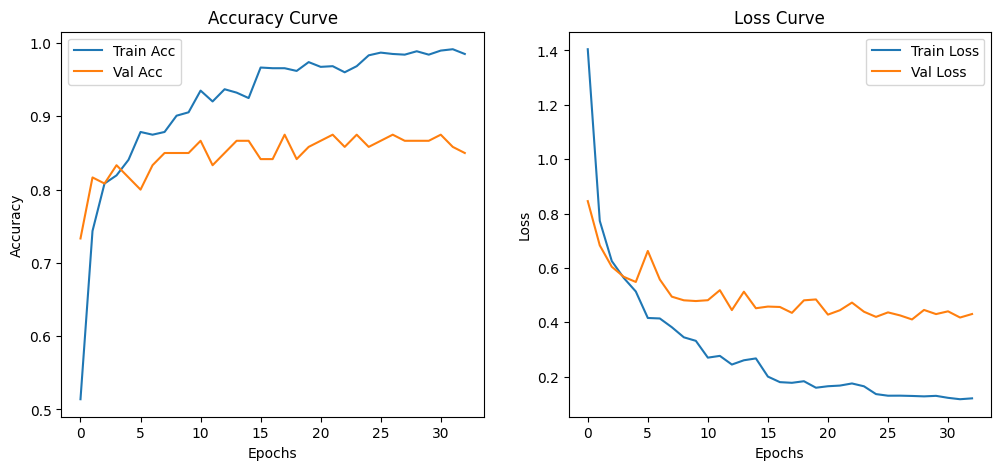


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     1.0000    0.9875    0.9937        80
Katari Siddho     0.7711    0.8000    0.7853        80
        Beroi     0.8500    0.8500    0.8500        80
        BR-29     1.0000    1.0000    1.0000        80
 Katari Najir     0.9630    0.9750    0.9689        80
      Miniket     0.9178    0.8375    0.8758        80
    Chinigura     0.8000    0.8500    0.8242        80
    Ghee Bhog     0.9091    0.7500    0.8219        80
        BR-28     0.9481    0.9125    0.9299        80
         Aush     0.8229    0.9875    0.8977        80

     accuracy                         0.8950       800
    macro avg     0.8982    0.8950    0.8948       800
 weighted avg     0.8982    0.8950    0.8948       800



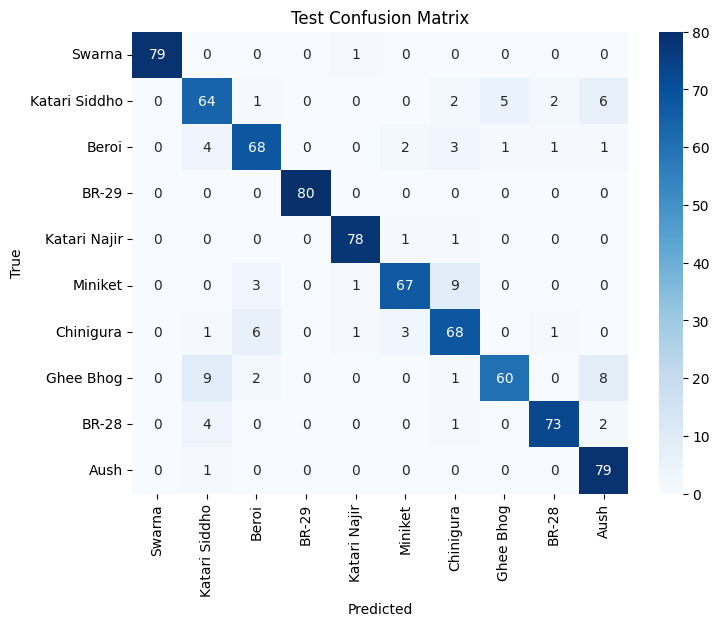

Swarna Accuracy: 0.9875
Katari Siddho Accuracy: 0.8000
Beroi Accuracy: 0.8500
BR-29 Accuracy: 1.0000
Katari Najir Accuracy: 0.9750
Miniket Accuracy: 0.8375
Chinigura Accuracy: 0.8500
Ghee Bhog Accuracy: 0.7500
BR-28 Accuracy: 0.9125
Aush Accuracy: 0.9875
Test AUC: 0.9917
Test PR AUC: 0.9451

Training Time: 359.50 seconds


In [5]:
#Model: NASNetMobile
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Paths and parameters

split_base_dir = '/kaggle/working/split_data'
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# Data generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model: NASNetMobile

def build_nasnetmobile_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

nasnet_model = build_nasnetmobile_model(num_classes=num_classes)
nasnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = nasnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time = time.time() - start_time


# Plot training curves

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluation function

def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, nasnet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, nasnet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, nasnet_model)


# Reports

print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# AUC & PR
print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")


Macro Precision: 0.8982
Macro Recall: 0.8950
Macro F1-score: 0.8948
Swarna: Precision=1.0000, Recall=0.9875, F1=0.9937
Katari Siddho: Precision=0.7711, Recall=0.8000, F1=0.7853
Beroi: Precision=0.8500, Recall=0.8500, F1=0.8500
BR-29: Precision=1.0000, Recall=1.0000, F1=1.0000
Katari Najir: Precision=0.9630, Recall=0.9750, F1=0.9689
Miniket: Precision=0.9178, Recall=0.8375, F1=0.8758
Chinigura: Precision=0.8000, Recall=0.8500, F1=0.8242
Ghee Bhog: Precision=0.9091, Recall=0.7500, F1=0.8219
BR-28: Precision=0.9481, Recall=0.9125, F1=0.9299
Aush: Precision=0.8229, Recall=0.9875, F1=0.8977


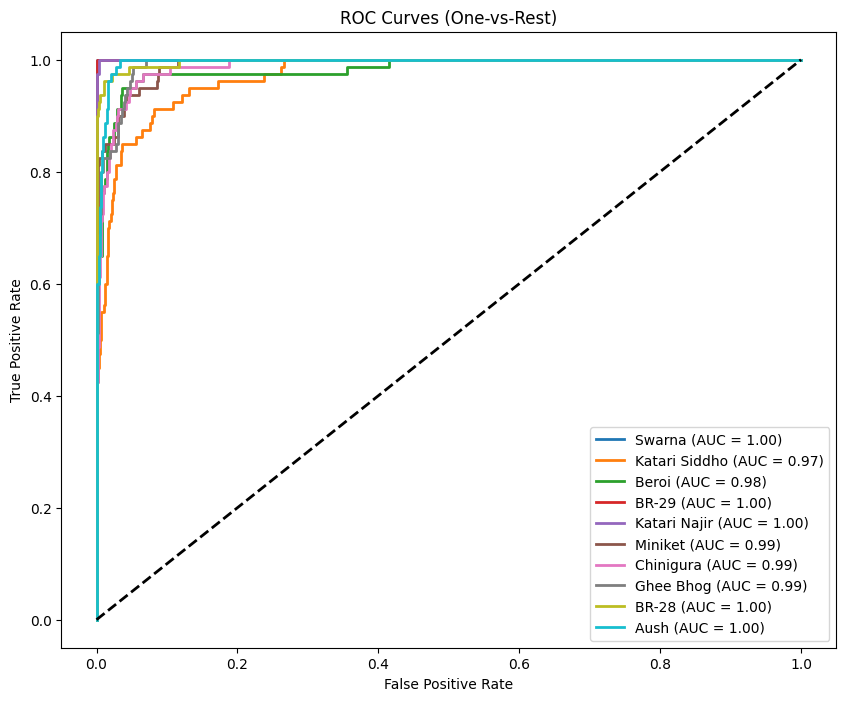

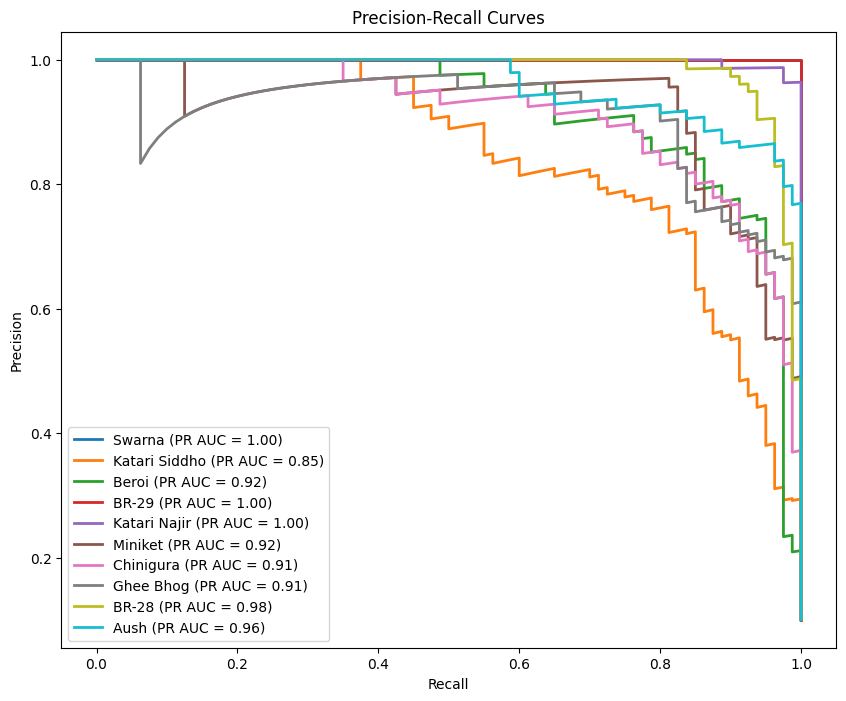

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 19.83 sec
Inference time per sample: 0.024784 sec

Most confused class pairs:
Swarna is most often confused with Katari Najir (1 samples)
Katari Siddho is most often confused with Aush (6 samples)
Beroi is most often confused with Katari Siddho (4 samples)
BR-29 is most often confused with Swarna (0 samples)
Katari Najir is most often confused with Miniket (1 samples)
Miniket is most often confused with Chinigura (9 samples)
Chinigura is most often confused with Beroi (6 samples)
Ghee Bhog is most often confused with Katari Siddho (9 samples)
BR-28 is most often confused with Katari Siddho (4 samples)
Aush is most often confused with Katari Siddho (1 samples)


In [6]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile

macro_precision = precision_score(test_true, test_pred, average='macro', zero_division=0)
macro_recall = recall_score(test_true, test_pred, average='macro', zero_division=0)
macro_f1 = f1_score(test_true, test_pred, average='macro', zero_division=0)

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# Per-class metrics
# -----------------------------
per_class_precision = precision_score(test_true, test_pred, average=None, zero_division=0)
per_class_recall = recall_score(test_true, test_pred, average=None, zero_division=0)
per_class_f1 = f1_score(test_true, test_pred, average=None, zero_division=0)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision-Recall curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Inference time per sample
# -----------------------------
nasnet_model = NASNetMobile(weights='imagenet', include_top=False)  # dummy, replace with your trained model
start_infer = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)  # test_gen = your test generator
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [7]:
start_test = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

Inference Time per sample: 0.008247 seconds


In [8]:
# Calculate and print the number of parameters
total_params = nasnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 4,269,716
Trainable Parameters: 4,232,978
Non-Trainable Parameters: 36,738


Found 980 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Found 800 images belonging to 10 classes.
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
31/31 - 46s - 1s/step - accuracy: 0.4061 - loss: 1.7347 - val_accuracy: 0.6700 - val_loss: 1.1961 - learning_rate: 0.0010
Epoch 2/50
31/31 - 19s - 622ms/step - accuracy: 0.6602 - loss: 1.0620 - val_accuracy: 0.7400 - val_loss: 0.8580 - learning_rate: 0.0010
Epoch 3/50
31/31 - 19s - 616ms/step - accuracy: 0.7092 - loss: 0.8629 - val_accuracy: 0.7800 - val_loss: 0.7927 - learning_rate: 0.0010
Epoch 4/50
31/31 - 19s - 598ms/step - accuracy: 0.7765 - loss: 0.7448 - val_accuracy: 0.7800 - val_loss: 0.8433 - learning_rate: 0.0010
Epoch 5/50
31/31 - 19s - 598ms/step - accuracy: 0.7990 - loss: 0.6633 - val_accuracy: 0.7500 - val_loss: 0.7598 - learning_rate: 0.0010
Epoch 6/50
31/31 - 19s - 604ms/step - accuracy: 0.8071 - loss: 0.6102 - val_accuracy: 0.7600 - val_loss: 0.7512 - learning_rate: 0.0010
Epoch 7/50
31/31 - 19s - 617ms/step - accuracy: 0.8133 - loss: 0.5837 - val_accuracy: 0.7900 - val_loss: 0.6271 - learning_rate: 0.0010
Epoch 8/50
31/31 - 19s - 603ms/step - accuracy: 0.8

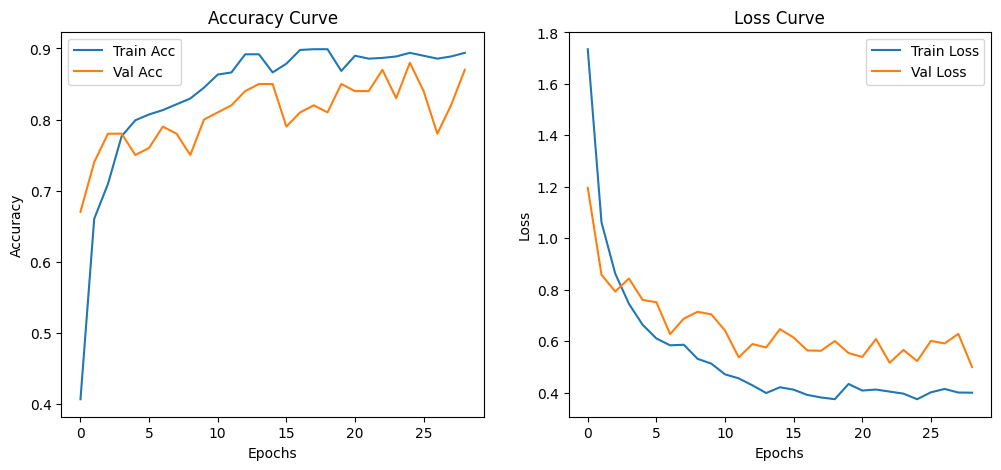


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9753    0.9875    0.9814        80
Katari Siddho     0.7204    0.8375    0.7746        80
        Beroi     0.8831    0.8500    0.8662        80
        BR-29     0.9873    0.9750    0.9811        80
 Katari Najir     1.0000    0.9875    0.9937        80
      Miniket     0.7238    0.9500    0.8216        80
    Chinigura     0.9773    0.5375    0.6935        80
    Ghee Bhog     0.7800    0.9750    0.8667        80
        BR-28     1.0000    0.8375    0.9116        80
         Aush     0.9333    0.8750    0.9032        80

     accuracy                         0.8812       800
    macro avg     0.8981    0.8812    0.8794       800
 weighted avg     0.8981    0.8812    0.8794       800



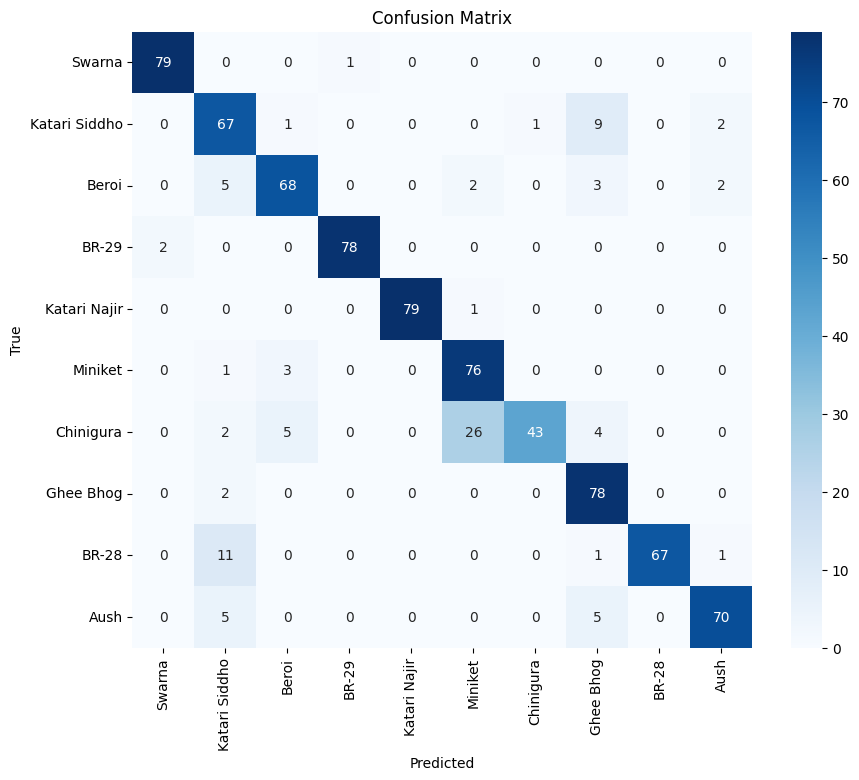

Swarna Accuracy: 0.9875
Katari Siddho Accuracy: 0.8375
Beroi Accuracy: 0.8500
BR-29 Accuracy: 0.9750
Katari Najir Accuracy: 0.9875
Miniket Accuracy: 0.9500
Chinigura Accuracy: 0.5375
Ghee Bhog Accuracy: 0.9750
BR-28 Accuracy: 0.8375
Aush Accuracy: 0.8750
Test AUC: 0.9933
Test PR AUC: 0.9592

Total Training Time: 386.30 seconds


In [9]:
#Model-2: ConvNeXtTiny
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
split_base_dir = '/kaggle/working/split_data'
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data Generators with Augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    validation_split=0.1  # 10% validation from 20% train+val
)

train_gen = train_datagen.flow_from_directory(
    split_base_dir+'/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    split_base_dir+'/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    split_base_dir+'/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Compute class weights
# -----------------------------
train_labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# -----------------------------
# Build ConvNeXtTiny model
# -----------------------------
def build_convnext_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze backbone initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

convnext_model = build_convnext_model(num_classes=num_classes)
convnext_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_convnext_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# -----------------------------
# Training (Frozen backbone) - 50 epochs
# -----------------------------
start_time = time.time()
history = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,   # 50 epochs frozen
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Fine-tuning (last 20 layers)
# -----------------------------
convnext_model.trainable = True
for layer in convnext_model.layers[:-20]:
    layer.trainable = False

convnext_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,   # fine-tuning for 10 epochs
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_ft.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_ft.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_ft.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, convnext_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, convnext_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, convnext_model)

print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTotal Training Time: {training_time:.2f} seconds")


Macro Precision: 0.8981
Macro Recall: 0.8812
Macro F1-score: 0.8794
Swarna: Precision=0.9753, Recall=0.9875, F1=0.9814
Katari Siddho: Precision=0.7204, Recall=0.8375, F1=0.7746
Beroi: Precision=0.8831, Recall=0.8500, F1=0.8662
BR-29: Precision=0.9873, Recall=0.9750, F1=0.9811
Katari Najir: Precision=1.0000, Recall=0.9875, F1=0.9937
Miniket: Precision=0.7238, Recall=0.9500, F1=0.8216
Chinigura: Precision=0.9773, Recall=0.5375, F1=0.6935
Ghee Bhog: Precision=0.7800, Recall=0.9750, F1=0.8667
BR-28: Precision=1.0000, Recall=0.8375, F1=0.9116
Aush: Precision=0.9333, Recall=0.8750, F1=0.9032


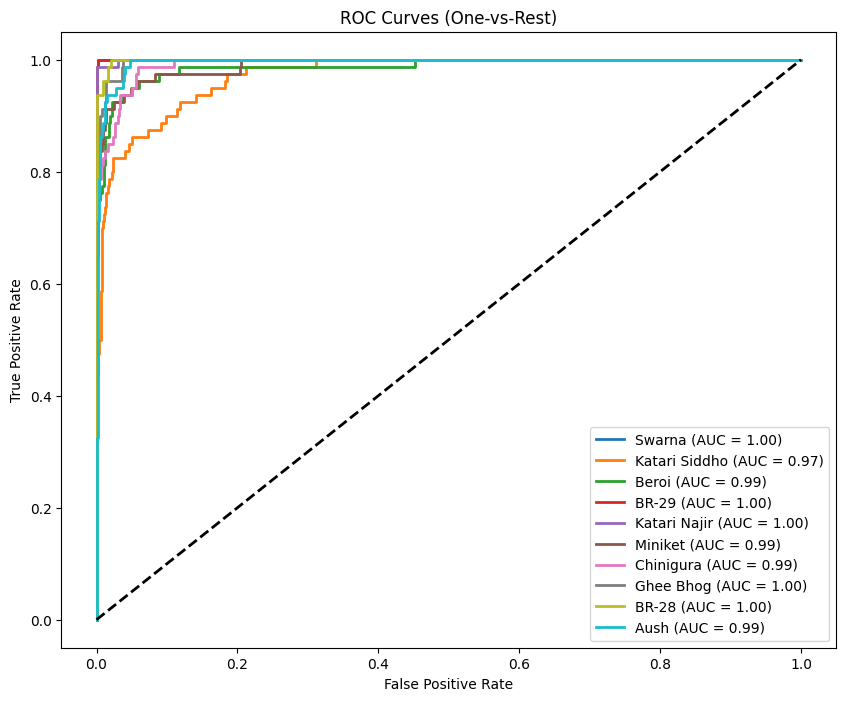

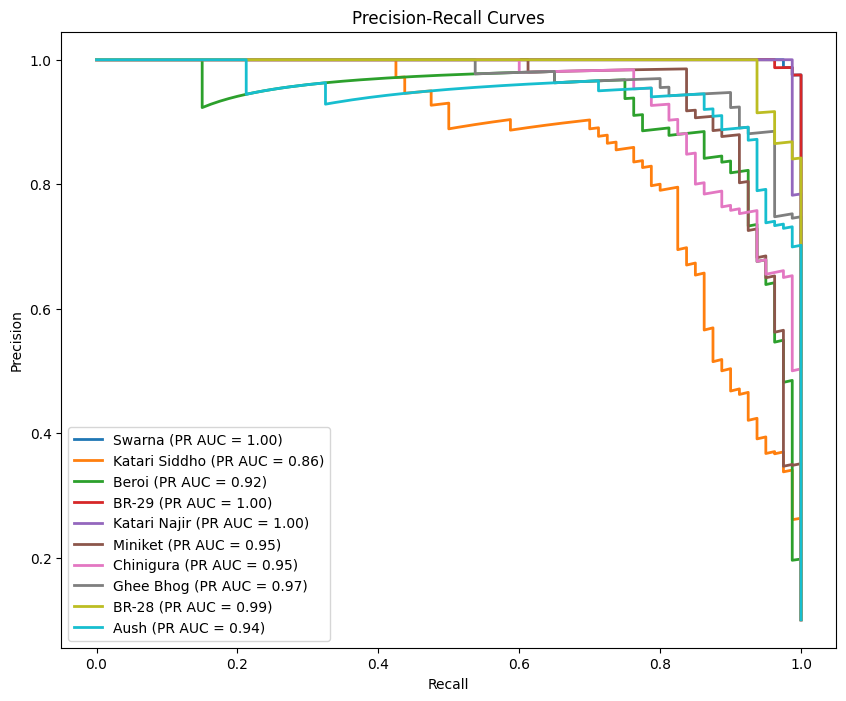


Most confused class pairs:
Swarna is most often confused with BR-29 (1 samples)
Katari Siddho is most often confused with Ghee Bhog (9 samples)
Beroi is most often confused with Katari Siddho (5 samples)
BR-29 is most often confused with Swarna (2 samples)
Katari Najir is most often confused with Miniket (1 samples)
Miniket is most often confused with Beroi (3 samples)
Chinigura is most often confused with Miniket (26 samples)
Ghee Bhog is most often confused with Katari Siddho (2 samples)
BR-28 is most often confused with Katari Siddho (11 samples)
Aush is most often confused with Katari Siddho (5 samples)


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [11]:
start_test = time.time()
_ = convnext_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.011971 seconds


In [12]:
# Calculate and print the number of parameters
total_params = convnext_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in convnext_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in convnext_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 28,218,986
Trainable Parameters: 398,858
Non-Trainable Parameters: 27,820,128


Found 1080 images belonging to 10 classes.
Found 120 images belonging to 10 classes.
Found 800 images belonging to 10 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
34/34 - 66s - 2s/step - accuracy: 0.4824 - loss: 1.6267 - val_accuracy: 0.6750 - val_loss: 1.0020 - learning_rate: 0.0010
Epoch 2/50
34/34 - 30s - 876ms/step - accuracy: 0.6991 - loss: 0.8874 - val_accuracy: 0.7667 - val_loss: 0.6813 - learning_rate: 0.0010
Epoch 3/50
34/34 - 30s - 872ms/step - accuracy: 0.7296 - loss: 0.7529 - val_accuracy: 0.8083 - val_loss: 0.6190 - learning_rate: 0.0010
Epoch 4/50
34/34 - 30s - 885ms/step - accuracy: 0.7519 - loss: 0.7216 - val_accuracy: 0.8167 - val_loss: 0.5728 - learning_rate: 0.0010
Epoch 5/50
34/34 - 30s - 879ms/step - accuracy: 0.7778 - loss: 0.6645 - val_accuracy: 0.7917 - val_loss: 0.5814 - learning_rate: 0.0010
Epoch 6/50
34/34 - 30s - 884ms/step - accuracy: 0.8056 - loss: 0.5906 - val_accuracy: 0.8417 - val_loss: 0.4950 - learning_rate: 0.0010
Epoch 7/5

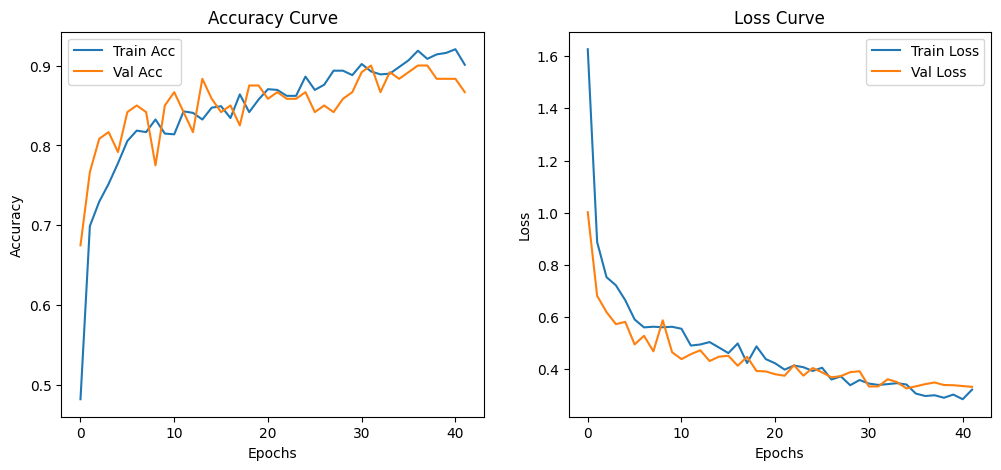


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9875    0.9875    0.9875        80
Katari Siddho     0.7419    0.8625    0.7977        80
        Beroi     0.8621    0.9375    0.8982        80
        BR-29     0.9875    0.9875    0.9875        80
 Katari Najir     1.0000    0.9625    0.9809        80
      Miniket     0.7755    0.9500    0.8539        80
    Chinigura     0.9474    0.6750    0.7883        80
    Ghee Bhog     0.9104    0.7625    0.8299        80
        BR-28     1.0000    0.9375    0.9677        80
         Aush     0.8605    0.9250    0.8916        80

     accuracy                         0.8988       800
    macro avg     0.9073    0.8988    0.8983       800
 weighted avg     0.9073    0.8988    0.8983       800



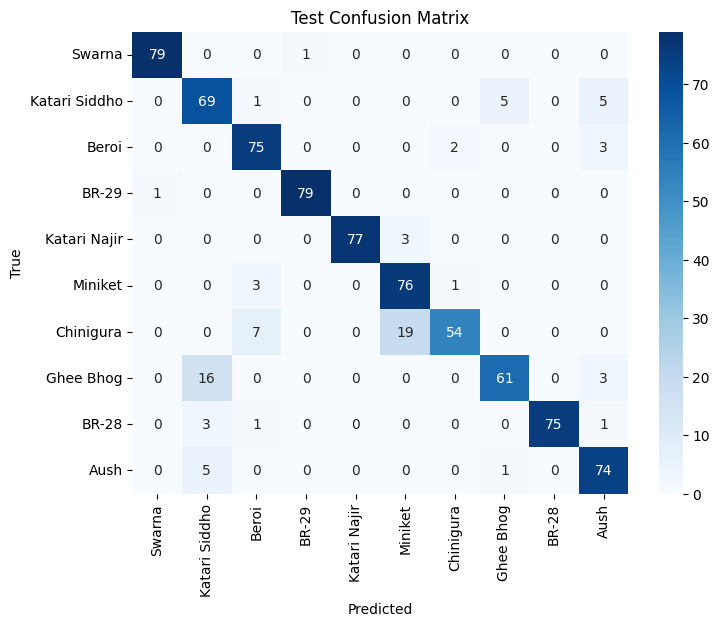

Swarna Accuracy: 0.9875
Katari Siddho Accuracy: 0.8625
Beroi Accuracy: 0.9375
BR-29 Accuracy: 0.9875
Katari Najir Accuracy: 0.9625
Miniket Accuracy: 0.9500
Chinigura Accuracy: 0.6750
Ghee Bhog Accuracy: 0.7625
BR-28 Accuracy: 0.9375
Aush Accuracy: 0.9250
Macro Precision: 0.9073, Macro Recall: 0.8988, Macro F1-score: 0.8983


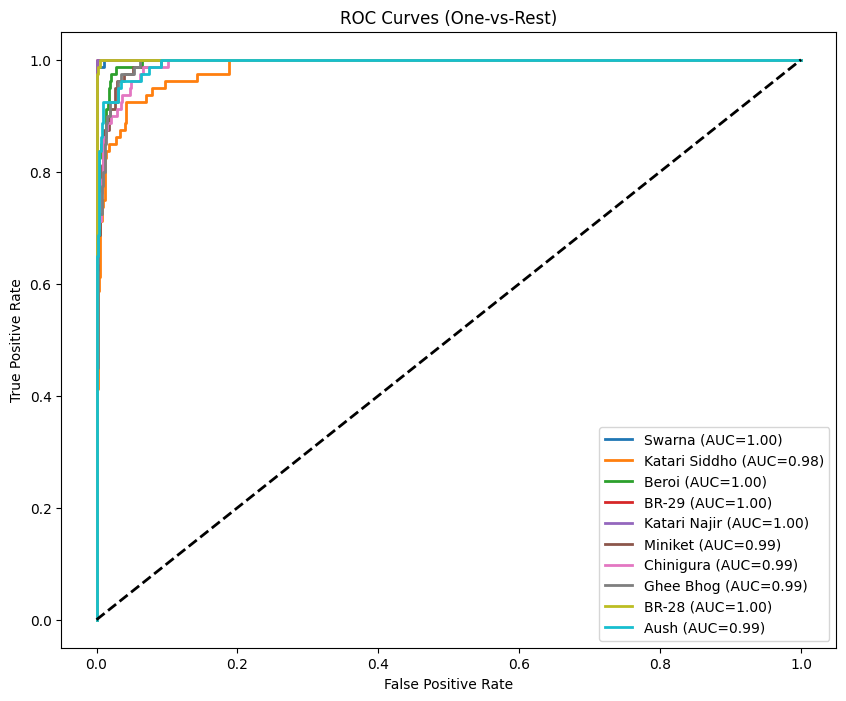

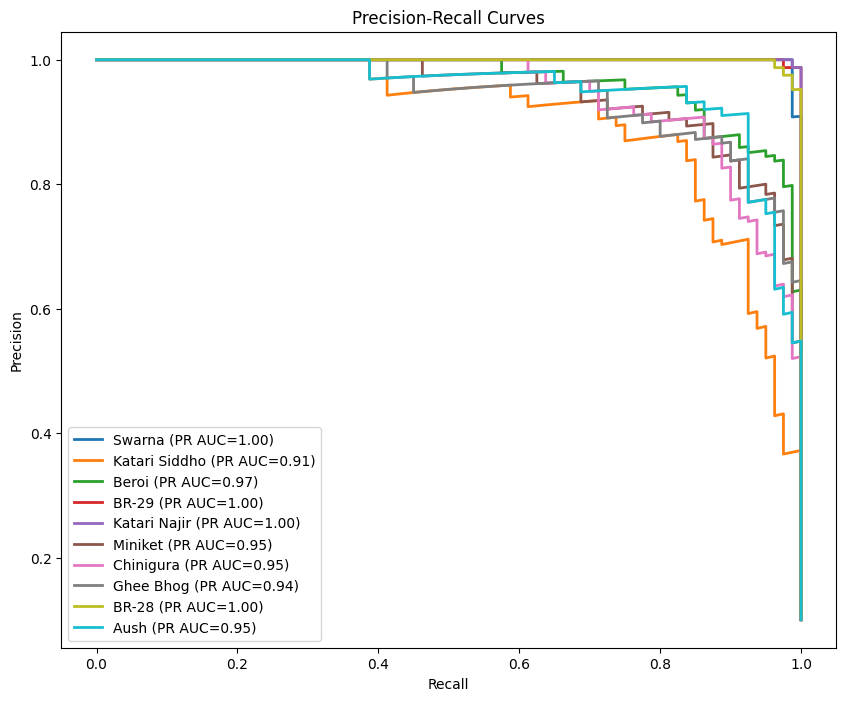


Most confused class pairs:
Swarna is most often confused with BR-29 (1 samples)
Katari Siddho is most often confused with Ghee Bhog (5 samples)
Beroi is most often confused with Aush (3 samples)
BR-29 is most often confused with Swarna (1 samples)
Katari Najir is most often confused with Miniket (3 samples)
Miniket is most often confused with Beroi (3 samples)
Chinigura is most often confused with Miniket (19 samples)
Ghee Bhog is most often confused with Katari Siddho (16 samples)
BR-28 is most often confused with Katari Siddho (3 samples)
Aush is most often confused with Katari Siddho (5 samples)


In [13]:
#Model-3:InceptionV3 

import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (299, 299)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators with augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Build InceptionV3 model
# -----------------------------
def build_inception_model(input_shape=(299,299,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

model, base_model = build_inception_model(num_classes=num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Train model for 50 epochs with early stopping
# -----------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, model)

# -----------------------------
# Classification report & confusion matrix
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# -----------------------------
# Per-class metrics
# -----------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')
print(f"Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# ROC-AUC & PR Curves
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Most confused classes
# -----------------------------
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [14]:
# Inference time per sample

start_test = time.time()
_ = model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.017312 seconds


In [15]:

# Model parameter summary
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")


Total Parameters: 22,857,002
Trainable Parameters: 1,054,218
Non-Trainable Parameters: 21,802,784


Found 1080 images belonging to 10 classes.
Found 120 images belonging to 10 classes.
Found 800 images belonging to 10 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.35833, saving model to best_resnet50_model.h5
68/68 - 56s - 817ms/step - accuracy: 0.2361 - loss: 2.1056 - val_accuracy: 0.3583 - val_loss: 2.0974 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_accuracy improved from 0.35833 to 0.46667, saving model to best_resnet50_model.h5
68/68 - 20s - 299ms/step - accuracy: 0.3093 - loss: 1.9479 - val_accuracy: 0.4667 - val_loss: 1.5999 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.46667
68/68 - 20s - 290ms/step - accuracy: 0.3491 - loss: 1.8352 - val_accuracy: 0.3000 - val_loss: 2.4073 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.46667
68/68 - 20s - 287ms/step - accuracy: 0.3444 - loss: 1.7988 - val_accuracy: 0.4583 - val_loss: 1.54

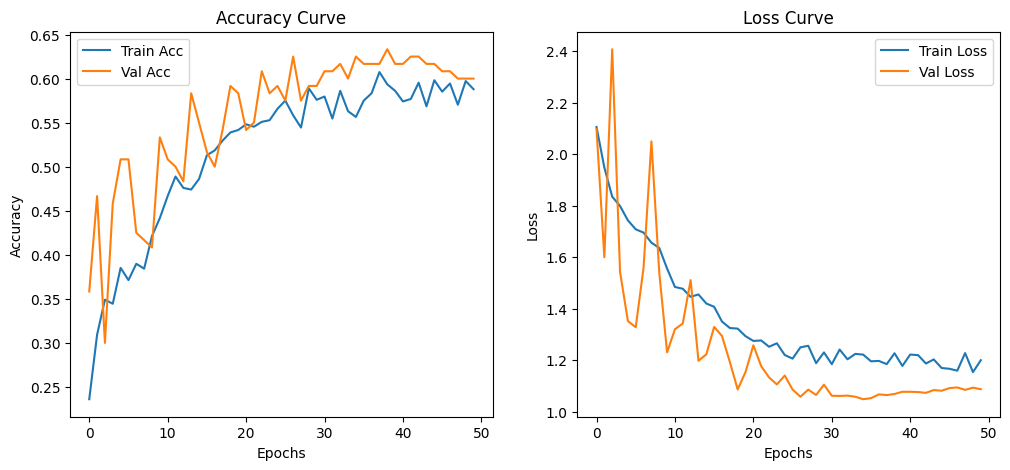


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.8953    0.9625    0.9277        80
Katari Siddho     0.6522    0.3750    0.4762        80
        Beroi     0.5844    0.5625    0.5732        80
        BR-29     0.9859    0.8750    0.9272        80
 Katari Najir     0.8167    0.6125    0.7000        80
      Miniket     0.4074    0.9625    0.5725        80
    Chinigura     0.9200    0.2875    0.4381        80
    Ghee Bhog     0.8113    0.5375    0.6466        80
        BR-28     0.7500    0.8625    0.8023        80
         Aush     0.6634    0.8375    0.7403        80

     accuracy                         0.6875       800
    macro avg     0.7487    0.6875    0.6804       800
 weighted avg     0.7487    0.6875    0.6804       800



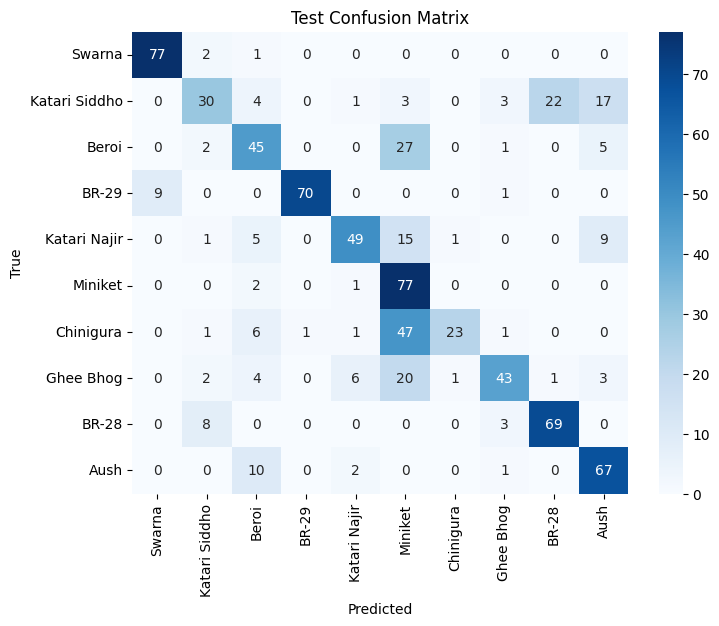

Swarna Accuracy: 0.9625
Katari Siddho Accuracy: 0.3750
Beroi Accuracy: 0.5625
BR-29 Accuracy: 0.8750
Katari Najir Accuracy: 0.6125
Miniket Accuracy: 0.9625
Chinigura Accuracy: 0.2875
Ghee Bhog Accuracy: 0.5375
BR-28 Accuracy: 0.8625
Aush Accuracy: 0.8375

Macro Precision: 0.7487
Macro Recall: 0.6875
Macro F1-score: 0.6804


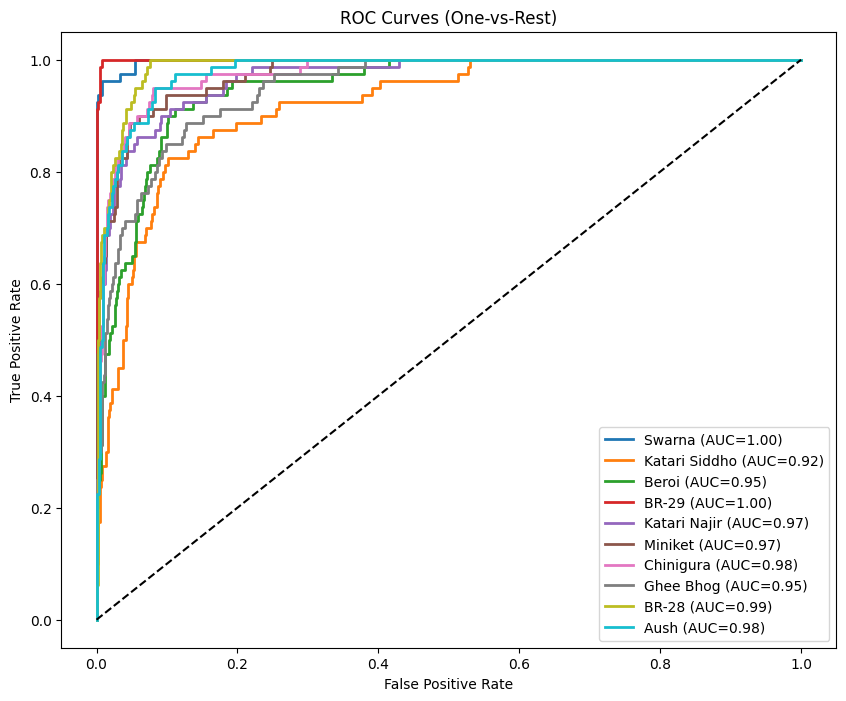

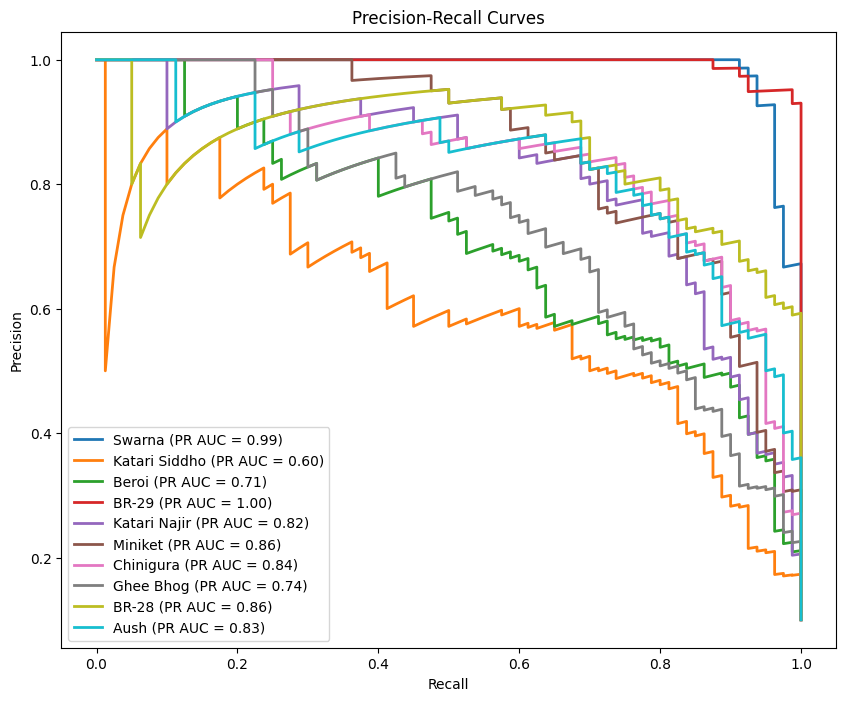


Most confused class pairs:
Swarna is most often confused with Katari Siddho (2 samples)
Katari Siddho is most often confused with BR-28 (22 samples)
Beroi is most often confused with Miniket (27 samples)
BR-29 is most often confused with Swarna (9 samples)
Katari Najir is most often confused with Miniket (15 samples)
Miniket is most often confused with Beroi (2 samples)
Chinigura is most often confused with Miniket (47 samples)
Ghee Bhog is most often confused with Miniket (20 samples)
BR-28 is most often confused with Katari Siddho (8 samples)
Aush is most often confused with Beroi (10 samples)


In [16]:
#Model-4: ResNet50
import os
import time
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)
batch_size = 16
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Build fine-tuned ResNet50 model
# -----------------------------
def build_resnet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Fine-tune last 30 layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

resnet_model = build_resnet_model(num_classes=num_classes)

# -----------------------------
# Compile model
# -----------------------------
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

start_time = time.time()

history = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, reduce_lr],
    verbose=2
)

training_time = time.time() - start_time
print(f"\nTotal Training Time: {training_time/60:.2f} minutes")

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true, y_pred_prob = [], []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, resnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# -----------------------------
# Metrics
# -----------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"\nMacro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# ROC–AUC Curves
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR Curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [17]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
print(f"Inference time per sample: {inference_time/test_gen.samples:.6f} sec")
print(f"Total inference time for {test_gen.samples} samples: {inference_time:.2f} sec")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference time per sample: 0.011983 sec
Total inference time for 800 samples: 9.59 sec


In [18]:
# -----------------------------
# Model parameters summary
# -----------------------------
total_params = resnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 24,641,930
Trainable Parameters: 15,504,394
Non-Trainable Parameters: 9,137,536


Found 1080 images belonging to 10 classes.
Found 120 images belonging to 10 classes.
Found 800 images belonging to 10 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
34/34 - 69s - 2s/step - accuracy: 0.5019 - loss: 1.5382 - val_accuracy: 0.6917 - val_loss: 0.8528 - learning_rate: 0.0010
Epoch 2/50
34/34 - 9s - 258ms/step - accuracy: 0.7537 - loss: 0.7224 - val_accuracy: 0.7750 - val_loss: 0.6025 - learning_rate: 0.0010
Epoch 3/50
34/34 - 9s - 251ms/step - accuracy: 0.8148 - loss: 0.5581 - val_accuracy: 0.7583 - val_loss: 0.6173 - learning_rate: 0.0010
Epoch 4/50
34/34 - 9s - 255ms/step - accuracy: 0.8333 - loss: 0.4846 - val_accuracy: 0.8250 - val_loss: 0.5512 - learning_rate: 0.0010
Epoch 5/50
34/34 - 9s - 260ms/step - accuracy: 0.8759 - loss: 0.3981 - val_accuracy: 0.8917 - val_loss: 0.3854 - learning_rate: 0.0010
Epoch 6/50
34/34 - 9s - 250ms/step - accuracy: 0.9019 - loss: 0.3378 - val_accuracy: 0.8500 - val_loss: 0.3940 - learning_rate: 0.0010
Epoch 7/50
34/

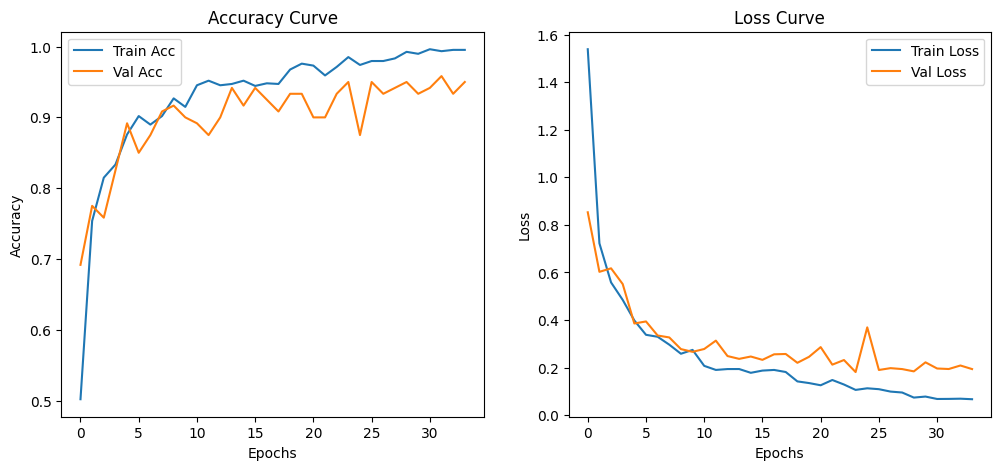


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     1.0000    0.9750    0.9873        80
Katari Siddho     0.8684    0.8250    0.8462        80
        Beroi     0.8452    0.8875    0.8659        80
        BR-29     0.9756    1.0000    0.9877        80
 Katari Najir     0.9634    0.9875    0.9753        80
      Miniket     0.8488    0.9125    0.8795        80
    Chinigura     0.8267    0.7750    0.8000        80
    Ghee Bhog     0.9221    0.8875    0.9045        80
        BR-28     0.9630    0.9750    0.9689        80
         Aush     0.9494    0.9375    0.9434        80

     accuracy                         0.9163       800
    macro avg     0.9163    0.9163    0.9159       800
 weighted avg     0.9163    0.9163    0.9159       800



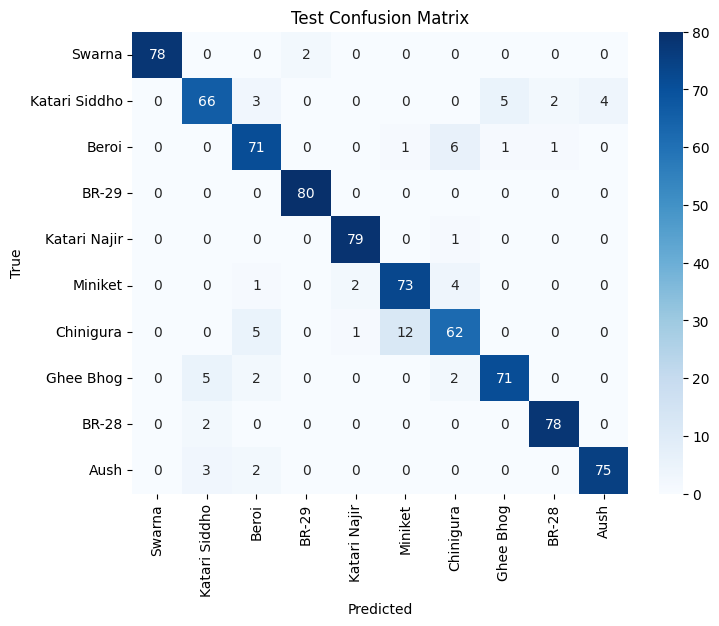

Swarna Accuracy: 0.9750
Katari Siddho Accuracy: 0.8250
Beroi Accuracy: 0.8875
BR-29 Accuracy: 1.0000
Katari Najir Accuracy: 0.9875
Miniket Accuracy: 0.9125
Chinigura Accuracy: 0.7750
Ghee Bhog Accuracy: 0.8875
BR-28 Accuracy: 0.9750
Aush Accuracy: 0.9375


In [19]:
# Mode5: DenseNet121

import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)  # DenseNet121 default input
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: DenseNet121
# -----------------------------
def build_densenet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

densenet_model = build_densenet_model(num_classes=num_classes)
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,  # increased epochs
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time = time.time() - start_time
print(f"Total training time: {training_time:.2f} sec")

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, densenet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, densenet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, densenet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")




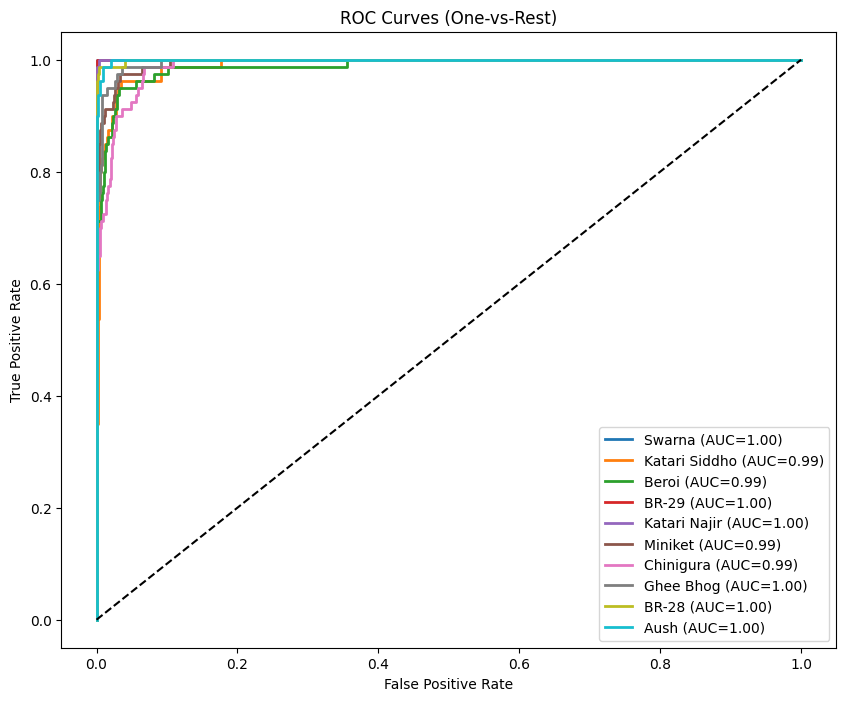

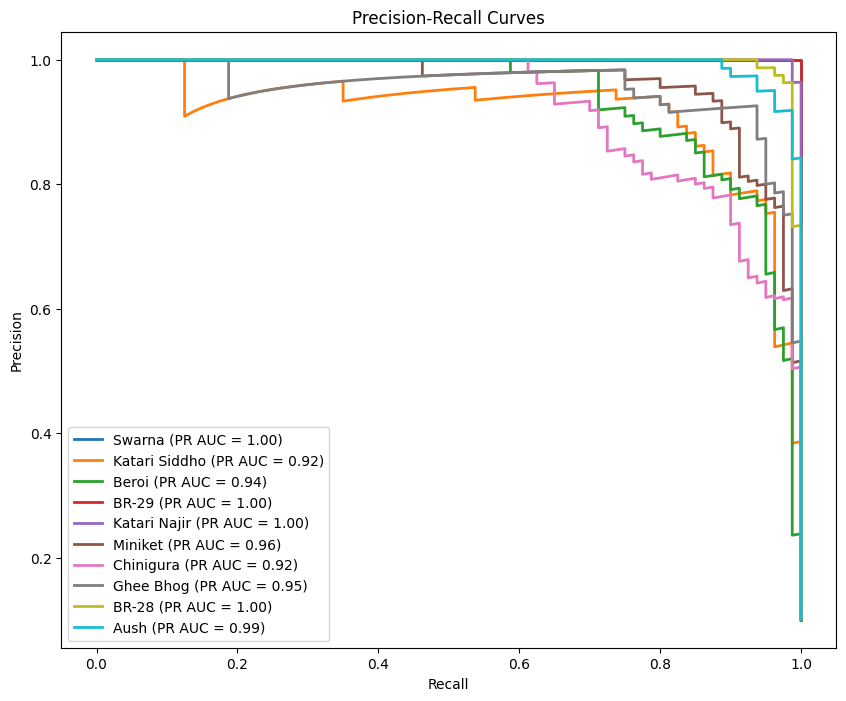


Most confused class pairs:
Swarna is most often confused with BR-29 (2 samples)
Katari Siddho is most often confused with Ghee Bhog (5 samples)
Beroi is most often confused with Chinigura (6 samples)
BR-29 is most often confused with Swarna (0 samples)
Katari Najir is most often confused with Chinigura (1 samples)
Miniket is most often confused with Chinigura (4 samples)
Chinigura is most often confused with Miniket (12 samples)
Ghee Bhog is most often confused with Katari Siddho (5 samples)
BR-28 is most often confused with Katari Siddho (2 samples)
Aush is most often confused with Katari Siddho (3 samples)

Total Training Time: 354.41 sec


In [20]:
 #ROC–AUC curves

y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision–Recall curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

print(f"\nTotal Training Time: {training_time:.2f} sec")

In [21]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.019963 seconds


In [22]:
# -----------------------------
# Calculate and print model parameters
# -----------------------------
total_params = densenet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 7,567,434
Trainable Parameters: 529,930
Non-Trainable Parameters: 7,037,504
